In [1]:
import numpy as np
import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
plotly.offline.init_notebook_mode(connected=True)

Shift matrix is defined as the matrix that repeats the signal with a given intensity weight according to:

$Y = MX_{original}$,
where
$ M = W\circ A$,
is the shift matrix defined by a multiplication of the weight matrix, $W$, and the repetition matrix, $A$.

In [2]:
class SimulateSpectra:
    def __init__(self, x):
        self.x = x
        self.peak_list = []
        
    def add_gaussian_line(self, A, x0, std):
        self.peak_list.append(A * (np.exp(-(self.x-x0)**2 /std )))

    def create_spectrum(self):
        self.spectrum = np.zeros(self.peak_list[0].shape)
        for peak in self.peak_list:
            self.spectrum += peak
            
    def define_shift_matrix(self, time_shifts, decay_weights):
        bins = self.spectrum.shape[0]
        self.shift_matrix = np.eye(bins)

        bin_shifts = []
        decays = []
        for (time_shift, weight) in zip(time_shifts, decay_weights):
            bin_shifts.append(self.get_bin_shift(time_shift))
            decays.append(weight)

        for (shift, decay) in zip(bin_shifts, decays):
            for bin in range(bins):
                iter_bin = bin
                while iter_bin + shift < bins:
                    self.shift_matrix[bin, iter_bin + shift] += decay
                    iter_bin += shift
        self.shift_matrix += self.shift_matrix.T
        np.fill_diagonal(self.shift_matrix, 1)
            
    def simulate_measurements(self, samples = 10, noise = 0.5):
        X = []
        bins = self.spectrum.shape[0]
        for sample in range(samples):
            sample_spectrum = self.shift_spectrum()
            sample_spectrum += np.abs(np.random.normal(0, noise, bins))
            X.append(sample_spectrum)
        X = np.array(X)
        return X


    
    def shift_spectrum(self):
        shifted_spectrum = np.dot(self.shift_matrix, self.spectrum.T)
        return shifted_spectrum

    def get_bin_shift(self, time_shift):
        return np.where(self.x >= time_shift)[0][0]



In [3]:
bins = 100
time_shifts = [100, 120]
decay_weights = [0.3, 0.5]

t = np.linspace(0, 500, bins)

simulation = SimulateSpectra(t)


simulation.add_gaussian_line(A=10, x0 = 173, std = 10)
simulation.add_gaussian_line(A=2, x0 = 147, std = 10)
simulation.add_gaussian_line(A=7, x0 = 202, std = 5)

simulation.create_spectrum()

simulation.define_shift_matrix(time_shifts = time_shifts, decay_weights = decay_weights)

samples = simulation.simulate_measurements(samples = 50, noise = 0.5)


Plot of the original spectrum, and three simulated measurement samples with shifted repetitions and added noise.

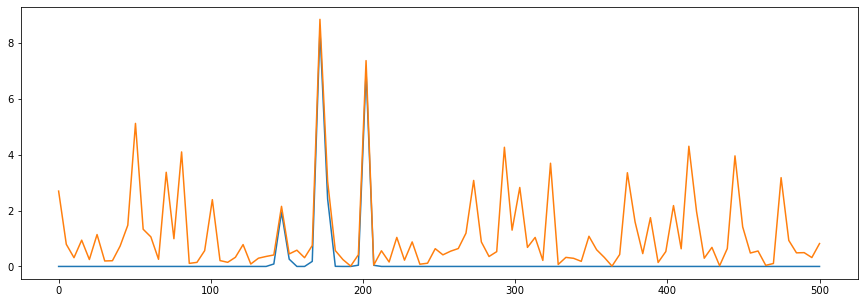

In [4]:
fig = plt.figure(figsize = (15,5))
plt.plot(t, simulation.spectrum)
#plt.plot(t, samples[0,:])
#plt.plot(t, samples[1,:])
plt.plot(t, samples[10,:])
plt.show()

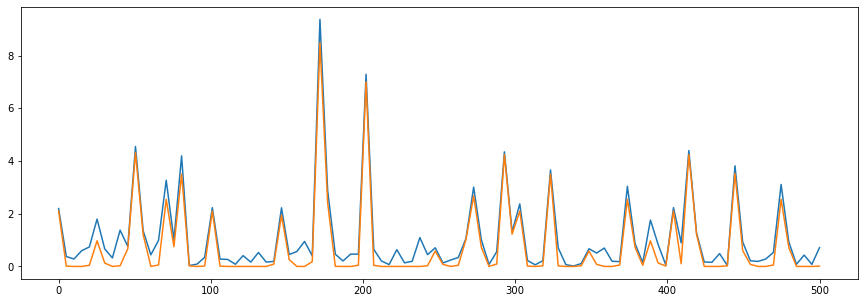

In [5]:
plt.figure(figsize = (15,5))
plt.plot(t, samples[0,:])
plt.plot(t, np.dot(simulation.shift_matrix, simulation.spectrum.T), '-')
plt.show()

The original signal $X_{original}$ is retrieved by computing the inverse

$X_{original} = M^{-1} Y$.

In [6]:
M_inv = np.linalg.inv(simulation.shift_matrix)
test_spec = np.dot(M_inv, np.mean(samples, 0))

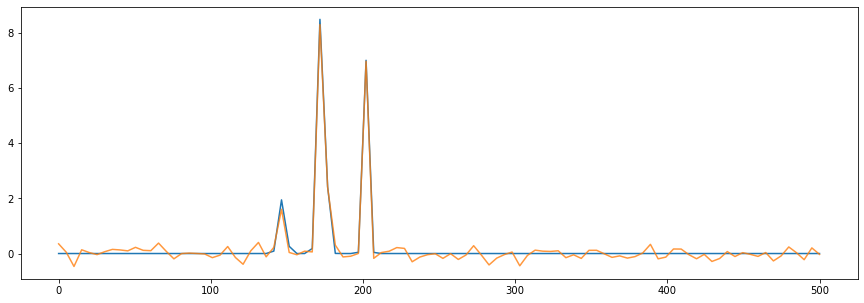

In [7]:
plt.figure(figsize = (15,5))
plt.plot(t, simulation.spectrum)
plt.plot(t, test_spec - np.median(test_spec), '-', alpha = 0.8)
plt.show()